In [ ]:
# default_exp quaternions
# default_cls_lvl 3

In [ ]:
#hide
%load_ext line_profiler
%matplotlib notebook

# Tensor Quaternion Module
> Pytorch Models for Sequential Data

In [ ]:
#export
from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *
from fastai2.callback.progress import *
from fastai2.callback.schedule import *

## Quaternion Type

In [ ]:
#export
class TensorQuaternionInclination(TensorSequences): pass
class TensorQuaternionAngle(TensorSequences): pass

In [ ]:
f_paths = '/mnt/Data/Systemidentification/Orientation_Estimation/'
hdf_files = get_hdf_files(f_paths)
tfm_src = CreateDict([DfHDFCreateWindows(win_sz=1000,stp_sz=100,clm='acc_x')])
u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z']
# u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','mag_x','mag_y','mag_z']
y =['opt_a','opt_b','opt_c','opt_d']
dls = DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),
                        SequenceBlock.from_hdf(y,TensorQuaternionInclination)),
                get_items=tfm_src,
                splitter=ApplyToDict(FuncSplitter(lambda o: 'experiment2' in str(o)))
               ).dataloaders(hdf_files,shufflish=True,bs=128)

## Basic Operations

In [ ]:
tq1 = tensor([
    [1,0,0,0],
    [0.5,0.5,0.5,0.5],
    ])
tq2 = tensor([
    [0.5,0.5,0.5,0.5],
    [0.5,0.5,0.5,0.5],
    ])
tq1.shape

torch.Size([2, 4])

In [ ]:
#export
_pi = torch.Tensor([3.14159265358979323846])
def rad2deg(t):
    return 180. * t / _pi.to(t.device).type(t.dtype)

In [ ]:
test_eq(float(rad2deg(_pi)),180)

In [ ]:
#export
def multiplyQuat(q1, q2):
    """quat1*quat2"""
    output = torch.zeros_like(q1)
    output[..., 0] = q1[..., 0] * q2[..., 0] - q1[..., 1] * q2[..., 1] - q1[..., 2] * q2[..., 2] - q1[..., 3] * q2[..., 3]
    output[..., 1] = q1[..., 0] * q2[..., 1] + q1[..., 1] * q2[..., 0] + q1[..., 2] * q2[..., 3] - q1[..., 3] * q2[..., 2]
    output[..., 2] = q1[..., 0] * q2[..., 2] - q1[..., 1] * q2[..., 3] + q1[..., 2] * q2[..., 0] + q1[..., 3] * q2[..., 1]
    output[..., 3] = q1[..., 0] * q2[..., 3] + q1[..., 1] * q2[..., 2] - q1[..., 2] * q2[..., 1] + q1[..., 3] * q2[..., 0]
    return output

In [ ]:
test_eq(multiplyQuat(tq1,tq2),tensor([[ 0.5000,  0.5000,  0.5000,  0.5000],
                                    [-0.5000,  0.5000,  0.5000,  0.5000]]))

In [ ]:
#export
def norm_quaternion(q):
    return q / q.norm(dim=-1)[...,None]

In [ ]:
test_eq(norm_quaternion(tq1*5),tq1)
test_eq(norm_quaternion(tq1/_pi),tq1)
test_eq(norm_quaternion(tq1[None,...]),tq1[None,...])

In [ ]:
#export
_conjugate_quaternion = tensor([1,-1,-1,-1])
def conjQuat(q):
    return q * _conjugate_quaternion.to(q.device).type(q.dtype)

In [ ]:
test_eq(conjQuat(tq1),tensor([[ 1.0000, -0.0000, -0.0000, -0.0000],
                             [ 0.5000, -0.5000, -0.5000, -0.5000]]))

In [ ]:
#export
def diffQuat(q1,q2,norm=True):
    if norm:
        nq1 = norm_quaternion(q1)
        nq2 = norm_quaternion(q2)
    else:
        nq1 = q1
        nq2 = q2
    return multiplyQuat(nq1, conjQuat(nq2))

In [ ]:
test_eq(diffQuat(tq1,tq2),diffQuat(tq1,tq2*5))
test_ne(diffQuat(tq1,tq2),diffQuat(tq1,tq2*5,norm=False))
test_ne(diffQuat(tq1,tq2),diffQuat(tq1[None,...],tq2[None,...]))

In [ ]:
#export
def safe_acos(t):
    '''numericaly stable variant of arcuscosine'''
    eps = 3e-8 #minimum value for acos(1) != 0
    return t.clamp(-1.0 + eps, 1.0 - eps).acos()

In [ ]:
test_ne(safe_acos(tensor(1.))*1e6,0)
test_eq(safe_acos(tensor(-0.)),_pi/2)

In [ ]:
#export
def inclinationAngle(q1,q2):
    
    q = diffQuat(q1,q2)
    return 2*safe_acos((q[..., 3]**2 + q[..., 0]**2).sqrt())

def relativeAngle(q1,q2):
    q = diffQuat(q1,q2)
    return 2*safe_acos((q[..., 0]).abs())

In [ ]:
print('inclination:', rad2deg(inclinationAngle(tq1,tq2)))
print('relative:', rad2deg(relativeAngle(tq1,tq2)))

inclination: tensor([9.0000e+01, 3.9565e-02])
relative: tensor([1.2000e+02, 3.9565e-02])


In [ ]:
#export
_unit_quaternion = tensor([1.,0,0,0])
def inclinationAngleAbs(q):
    q = diffQuat(q,_unit_quaternion[None,:])
    return 2*safe_acos((q[..., 3]**2 + q[..., 0]**2).sqrt())

In [ ]:
rad2deg(inclinationAngleAbs(tq1))

tensor([3.9565e-02, 9.0000e+01])

## Loss Functions

In [ ]:
#export
def ms_inclination(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  (inclination**2).mean()

In [ ]:
ms_inclination(tq1,tq2)

tensor(1.2337)

In [ ]:
#export
def rms_inclination_deg(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  rad2deg((inclination**2).mean().sqrt())

In [ ]:
rms_inclination_deg(tq1,tq2)

tensor([63.6396])

In [ ]:
#export
def mean_inclination_deg(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  rad2deg(inclination.mean())

In [ ]:
mean_inclination_deg(tq1,tq2)

tensor([45.0198])

In [ ]:
#export
def ms_rel_angle(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  (rel_angle**2).mean()

In [ ]:
ms_rel_angle(tq1,tq2)

tensor(2.1932)

In [ ]:
#export
def rms_rel_angle_deg(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  rad2deg((rel_angle**2).mean().sqrt())

In [ ]:
rms_rel_angle_deg(tq1,tq2)

tensor([84.8528])

In [ ]:
#export
def mean_rel_angle_deg(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  rad2deg(rel_angle.mean())

In [ ]:
mean_rel_angle_deg(tq1,tq2)

tensor([60.0198])

## Callbacks

In order to assure that the output of the model are close to unit quaternions the distance will be added to the loss

In [ ]:
#export
from fastai2.callback.hook import *
@delegates()
class QuaternionRegularizer(HookCallback):
    "Callback that adds AR and TAR to the loss, calculated by output of provided layer"
    run_before=TrainEvalCallback
    def __init__(self,reg_unit=0.0,detach=False, **kwargs):
        super().__init__(detach=detach,**kwargs)
        store_attr(self,'reg_unit')
        
    def hook(self, m, i, o): 
        if type(o) is torch.Tensor:
            self.out = o
        else:
            self.out = o[0]
    
    def after_loss(self):
        if not self.training: return
        h = self.out.float()
        
        if self.reg_unit != 0.:  
            l_a = float(self.reg_unit) * ((1-h.norm(dim=-1))**2).mean()
#             import pdb; pdb.set_trace()
            self.learn.loss += l_a 

In [ ]:
n_skip = 2**8

inp,out = get_inp_out_size(dls)
# model = SimpleGRU(inp,out,num_layers=1,hidden_size=100)
model = TCN(inp,out,hl_depth=8,hl_width=10)

skip = partial(SkipNLoss,n_skip=n_skip)
metrics=rms_inclination_deg
cbs = [QuaternionRegularizer(reg_unit=1,modules=[model])]

lrn = Learner(dls,model,loss_func=ms_inclination,opt_func=ranger,metrics=metrics)

In [ ]:
lrn.fit_one_cycle(5,lr_max=3e-3)

epoch,train_loss,valid_loss,rms_inclination_deg,time
0,1.266422,0.663090,39.970524,00:05
1,0.541348,0.296757,25.654890,00:05
2,0.287095,0.181305,19.786039,00:05
3,0.189484,0.140640,17.336233,00:05
4,0.156057,0.137173,17.077860,00:05


## Inclination Datablock

In [ ]:
class TensorInclination(TensorSequences): pass

In [ ]:
#export
import h5py
class HDF2Inclination(HDF2Sequence):
        
    def _hdf_extract_sequence(self,hdf_path,dataset = None, l_slc = None, r_slc= None,down_s=None):
        with h5py.File(hdf_path,'r') as f:
            ds = f if dataset is None else f[dataset]
            l_array = [ds[n][l_slc:r_slc] for n in self.clm_names]
            seq = np.vstack(l_array).T
            seq = array(rad2deg(inclinationAngleAbs(tensor(seq))[:,None]))
            return seq

In [ ]:
#export
class InclinationBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Normalize(axes=[0,1])],
                                dls_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Inclination, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorInclination,padding=False, **kwargs):
        return cls(HDF2Inclination(clm_names,to_cls=seq_cls,**kwargs), padding)


In [ ]:
f_paths = '/mnt/Data/Systemidentification/Orientation_Estimation/'
hdf_files = get_hdf_files(f_paths)
tfm_src = CreateDict([DfHDFCreateWindows(win_sz=1000,stp_sz=100,clm='acc_x')])
u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z']
# u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','mag_x','mag_y','mag_z']
y =['opt_a','opt_b','opt_c','opt_d']
dls = DataBlock(blocks=(SequenceBlock.from_hdf(u),
                        InclinationBlock.from_hdf(y)),
                get_items=tfm_src,
                splitter=ApplyToDict(FuncSplitter(lambda o: 'experiment2' in str(o)))
               ).dataloaders(hdf_files,shufflish=True,bs=128)

<IPython.core.display.Javascript object>


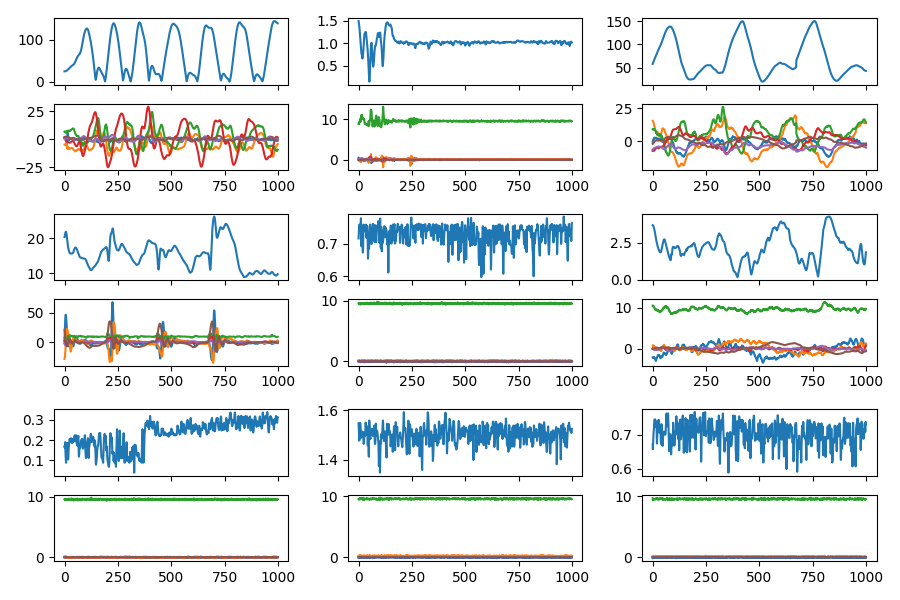

In [ ]:
dls.show_batch()

## Show Results

In [ ]:
#export
def plot_inclination(axs,in_sig,targ_sig,out_sig=None):
#     import pdb; pdb.set_trace()
    first_targ = targ_sig[0].repeat(targ_sig.shape[0],1)
    axs[0].plot(rad2deg(inclinationAngle(first_targ,targ_sig)))
    axs[0].label_outer()
    axs[0].legend(['y'])
    axs[0].set_ylabel('inclination[°]')
    
    if out_sig is not None:
        axs[0].plot(rad2deg(inclinationAngle(first_targ,out_sig)))
        axs[0].legend(['y','ŷ'])
        axs[1].plot(rad2deg(inclinationAngle(out_sig,targ_sig)))
        axs[1].label_outer()
        axs[1].set_ylabel('error[°]')
        
    axs[-1].plot(in_sig)

In [ ]:
#export
def plot_rel_angle(axs,in_sig,targ_sig,out_sig=None):
#     import pdb; pdb.set_trace()
    first_targ = targ_sig[0].repeat(targ_sig.shape[0],1)
    axs[0].plot(rad2deg(relativeAngle(first_targ,targ_sig)))
    axs[0].label_outer()
    axs[0].legend(['y'])
    axs[0].set_ylabel('angle[°]')
    
    if out_sig is not None:
        axs[0].plot(rad2deg(relativeAngle(first_targ,out_sig)))
        axs[0].legend(['y','ŷ'])
        axs[1].plot(rad2deg(relativeAngle(out_sig,targ_sig)))
        axs[1].label_outer()
        axs[1].set_ylabel('error[°]')
        
    axs[-1].plot(in_sig)

In [ ]:
dls.show_batch(max_n=3,ds_idx=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#export
@typedispatch
def show_results(x:TensorSequences, y:TensorQuaternionInclination, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 2
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_inclination,outs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_inclination,outs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_batch(x:TensorSequences, y:TensorQuaternionInclination, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 1
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_inclination)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_inclination)
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorSequences, y:TensorQuaternionAngle, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 2
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_rel_angle,outs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_rel_angle,outs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_batch(x:TensorSequences, y:TensorQuaternionAngle, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 1
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_rel_angle)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_rel_angle)
    return ctxs

In [ ]:
lrn.show_results(max_n=3,ds_idx=0,shuffle=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_model.ipynb.
Converted 02_learner.ipynb.
Converted 11_ProDiag.ipynb.
Converted 12_TensorQuaternions.ipynb.
Converted 13_PBT.ipynb.
Converted index.ipynb.
